In [3]:
import os
import random
from pathlib import Path
from functools import partial

In [5]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
import timm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import joblib


c:\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)

Device: cuda


In [19]:
# Параметры
DATA_DIR = "./data"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 4
NUM_EPOCHS = 30
LR = 1e-4
MODEL_DIR = "./saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
# Загрузчик датасета (Oxford-IIIT Pet) и трансформации
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
dataset = OxfordIIITPet(root=DATA_DIR, download=True, transform=None)
full_dataset = OxfordIIITPet(root=DATA_DIR, download=False, transform=val_transforms)
all_labels = [full_dataset[i][1] for i in range(len(full_dataset))]
num_classes = len(set(all_labels))

print("Dataset size:", len(full_dataset))
print("Number of classes:", num_classes)

Dataset size: 3680
Number of classes: 37


In [13]:
# Разделение датасета на обучающую, валидационную и тестовую выборки
n = len(full_dataset)
train_len = int(0.8 * n)
val_len = int(0.1 * n)
test_len = n - train_len - val_len
train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len],
                                         generator=torch.Generator().manual_seed(SEED))

In [14]:
# Применение трансформаций и создание DataLoader-ов
train_ds.dataset.transform = train_transforms
val_ds.dataset.transform = val_transforms
test_ds.dataset.transform = val_transforms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [15]:
# Утилиты: тренировка и оценка (общие функции)
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    return running_loss / total, correct / total

In [ ]:
# Модель 1: RandomForest — извлечение признаков через предобученный ResNet18 (avgpool)
fe_extractor = timm.create_model("resnet18", pretrained=True, num_classes=0, global_pool="avg")
fe_extractor.eval()
fe_extractor.to(device)

def extract_features(loader, model, device):
    feats = []
    labels = []
    with torch.no_grad():
        for imgs, lbl in loader:
            imgs = imgs.to(device)
            f = model(imgs)  # output shape (N, feat_dim)
            feats.append(f.cpu().numpy())
            labels.append(lbl.numpy())
    feats = np.concatenate(feats, axis=0)
    labels = np.concatenate(labels, axis=0)
    return feats, labels

# Экстракция признаков
train_feats, train_labels = extract_features(train_loader, fe_extractor, device)
val_feats, val_labels = extract_features(val_loader, fe_extractor, device)
test_feats, test_labels = extract_features(test_loader, fe_extractor, device)

# Тренировка и оценка RandomForest
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=SEED)
rf.fit(train_feats, train_labels)
val_preds = rf.predict(val_feats)
print("RandomForest val accuracy:", accuracy_score(val_labels, val_preds))
joblib.dump(rf, os.path.join(MODEL_DIR, "random_forest_oxford_pet.joblib"))

c:\Python314\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


RandomForest val accuracy: 0.8940217391304348


['./saved_models\\random_forest_oxford_pet.joblib']

In [20]:
# Модель 2: CNN 
class MyCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1, dropout=0.3):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout)
            )
        
        # Residual блок
        class ResidualBlock(nn.Module):
            def __init__(self, channels):
                super().__init__()
                self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
                self.bn1 = nn.BatchNorm2d(channels)
                self.relu = nn.ReLU(inplace=True)
                self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
                self.bn2 = nn.BatchNorm2d(channels)
            def forward(self, x):
                identity = x
                out = self.relu(self.bn1(self.conv1(x)))
                out = self.bn2(self.conv2(out))
                out += identity
                return self.relu(out)
        
        self.feature = nn.Sequential(
            conv_block(3, 32),
            nn.MaxPool2d(2),
            
            conv_block(32, 64),
            ResidualBlock(64),
            nn.MaxPool2d(2),
            
            conv_block(64, 128),
            ResidualBlock(128),
            nn.MaxPool2d(2),
            
            conv_block(128, 256),
            ResidualBlock(256),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x

cnn_model = MyCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LR)

best_acc = 0.0
for epoch in range(NUM_EPOCHS):
    tr_loss, tr_acc = train_one_epoch(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_model(cnn_model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | train acc {tr_acc:.4f} | val acc {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(cnn_model.state_dict(), os.path.join(MODEL_DIR, "simple_cnn_oxford_pet.pth"))
print("Best CNN val acc:", best_acc)

Epoch 1/30 | train acc 0.0367 | val acc 0.0190
Epoch 2/30 | train acc 0.0510 | val acc 0.0217
Epoch 3/30 | train acc 0.0639 | val acc 0.0245
Epoch 4/30 | train acc 0.0781 | val acc 0.0408
Epoch 5/30 | train acc 0.0866 | val acc 0.0353
Epoch 6/30 | train acc 0.0907 | val acc 0.0380
Epoch 7/30 | train acc 0.1026 | val acc 0.0326
Epoch 8/30 | train acc 0.1131 | val acc 0.0489
Epoch 9/30 | train acc 0.1145 | val acc 0.0299
Epoch 10/30 | train acc 0.1338 | val acc 0.0380
Epoch 11/30 | train acc 0.1478 | val acc 0.0543
Epoch 12/30 | train acc 0.1552 | val acc 0.0598
Epoch 13/30 | train acc 0.1627 | val acc 0.0761
Epoch 14/30 | train acc 0.1804 | val acc 0.0543
Epoch 15/30 | train acc 0.1872 | val acc 0.0679
Epoch 16/30 | train acc 0.1953 | val acc 0.0815
Epoch 17/30 | train acc 0.1977 | val acc 0.0707
Epoch 18/30 | train acc 0.2198 | val acc 0.0815
Epoch 19/30 | train acc 0.2177 | val acc 0.0761
Epoch 20/30 | train acc 0.2327 | val acc 0.0679
Epoch 21/30 | train acc 0.2371 | val acc 0.0815
E

In [34]:
# Модель 3: ResNet50 с дообучением
from torchvision.models import resnet50, ResNet50_Weights

# предобученные веса
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=LR, weight_decay=1e-4)

best_acc = 0.0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

early_patience = 2
no_improve_epochs = 0
epochs_resnet = 10

for epoch in range(epochs_resnet):
    tr_loss, tr_acc = train_one_epoch(resnet, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_model(resnet, val_loader, criterion, device)
    scheduler.step(val_acc)
    print(f"ResNet Epoch {epoch+1}/{epochs_resnet} | train acc {tr_acc:.4f} | val acc {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(resnet.state_dict(), os.path.join(MODEL_DIR, "resnet50_oxford_pet.pth"))
        no_improve_epochs = 0  
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_patience:
            print(f"Early stopping на эпохе {epoch+1} (нет улучшений {early_patience} эпох подряд)")
            break

print("Best ResNet val acc:", best_acc)


ResNet Epoch 1/10 | train acc 0.6291 | val acc 0.9212
ResNet Epoch 2/10 | train acc 0.9402 | val acc 0.9293
ResNet Epoch 3/10 | train acc 0.9803 | val acc 0.9348
ResNet Epoch 4/10 | train acc 0.9885 | val acc 0.9375
ResNet Epoch 5/10 | train acc 0.9881 | val acc 0.9348
ResNet Epoch 6/10 | train acc 0.9912 | val acc 0.9375
Early stopping на эпохе 6 (нет улучшений 2 эпох подряд)
Best ResNet val acc: 0.9375


In [ ]:
# Модель 4: EfficientNet (timm) — efficientnet_b0
effnet = timm.create_model("efficientnet_b0", pretrained=True, num_classes=num_classes)
effnet = effnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(effnet.parameters(), lr=LR, weight_decay=1e-4)

epochs_effnet = 10

best_acc = 0.0
for epoch in range(epochs_effnet):
    tr_loss, tr_acc = train_one_epoch(effnet, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_model(effnet, val_loader, criterion, device)
    scheduler.step(val_acc)
    print(f"EffNet Epoch {epoch+1}/{epochs_effnet} | train acc {tr_acc:.4f} | val acc {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(effnet.state_dict(), os.path.join(MODEL_DIR, "efficientnet_b0_oxford_pet.pth"))
print("Best EfficientNet val acc:", best_acc)

EffNet Epoch 1/10 | train acc 0.3910 | val acc 0.7065
EffNet Epoch 2/10 | train acc 0.8808 | val acc 0.8098
EffNet Epoch 3/10 | train acc 0.9674 | val acc 0.8505
EffNet Epoch 4/10 | train acc 0.9901 | val acc 0.8533
EffNet Epoch 5/10 | train acc 0.9963 | val acc 0.8614
EffNet Epoch 6/10 | train acc 0.9980 | val acc 0.8668
EffNet Epoch 7/10 | train acc 0.9993 | val acc 0.8696
EffNet Epoch 8/10 | train acc 0.9993 | val acc 0.8668


Exception ignored while calling deallocator <function _MultiProcessingDataLoaderIter.__del__ at 0x000001357FA63ED0>:
Traceback (most recent call last):
  File "c:\Python314\Lib\site-packages\torch\utils\data\dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "c:\Python314\Lib\site-packages\torch\utils\data\dataloader.py", line 1612, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


EffNet Epoch 9/10 | train acc 0.9993 | val acc 0.8723
EffNet Epoch 10/10 | train acc 0.9993 | val acc 0.8750
Best EfficientNet val acc: 0.875


In [37]:
# Модель 5: ViT (timm) — vit_base_patch16_224
vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
vit = vit.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=LR, weight_decay=1e-4)

epochs_vit = 8

best_acc = 0.0
for epoch in range(epochs_vit):
    tr_loss, tr_acc = train_one_epoch(vit, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval_model(vit, val_loader, criterion, device)
    scheduler.step(val_acc)
    print(f"ViT Epoch {epoch+1}/{epochs_vit} | train acc {tr_acc:.4f} | val acc {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(vit.state_dict(), os.path.join(MODEL_DIR, "vit_base_oxford_pet.pth"))
print("Best ViT val acc:", best_acc)

c:\Python314\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--timm--vit_base_patch16_224.augreg2_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


ViT Epoch 1/8 | train acc 0.6953 | val acc 0.8098
ViT Epoch 2/8 | train acc 0.9276 | val acc 0.8560
ViT Epoch 3/8 | train acc 0.9701 | val acc 0.8478
ViT Epoch 4/8 | train acc 0.9694 | val acc 0.8071
ViT Epoch 5/8 | train acc 0.9708 | val acc 0.8234
ViT Epoch 6/8 | train acc 0.9528 | val acc 0.8587
ViT Epoch 7/8 | train acc 0.9742 | val acc 0.8397
ViT Epoch 8/8 | train acc 0.9772 | val acc 0.7962
Best ViT val acc: 0.8586956521739131


In [ ]:
# Проверка на тесте
# 1. RandomForest
rf = joblib.load(os.path.join(MODEL_DIR, "random_forest_oxford_pet.joblib"))
rf_test_preds = rf.predict(test_feats)
print("RandomForest test acc:", accuracy_score(test_labels, rf_test_preds))

RandomForest test acc: 0.8831521739130435


In [ ]:
# 2. CNN
cnn = MyCNN(num_classes=num_classes)
cnn.load_state_dict(torch.load(os.path.join(MODEL_DIR, "simple_cnn_oxford_pet.pth"), map_location="cpu"))
cnn.to(device)
_, cnn_test_acc = eval_model(cnn, test_loader, nn.CrossEntropyLoss(), device)
print("Simple CNN test acc:", cnn_test_acc)

Simple CNN test acc: 0.07608695652173914


In [ ]:
# 3. ResNet
resnet = timm.create_model("resnet50", pretrained=False, num_classes=num_classes)
resnet.load_state_dict(torch.load(os.path.join(MODEL_DIR, "resnet50_oxford_pet.pth"), map_location="cpu"))
resnet.to(device)
_, resnet_test_acc = eval_model(resnet, test_loader, nn.CrossEntropyLoss(), device)
print("ResNet test acc:", resnet_test_acc)

Exception ignored while calling deallocator <function _MultiProcessingDataLoaderIter.__del__ at 0x000001357FA63ED0>:
Traceback (most recent call last):
  File "c:\Python314\Lib\site-packages\torch\utils\data\dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "c:\Python314\Lib\site-packages\torch\utils\data\dataloader.py", line 1612, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


ResNet test acc: 0.9429347826086957


In [ ]:
# 4. EfficientNet
eff = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes)
eff.load_state_dict(torch.load(os.path.join(MODEL_DIR, "efficientnet_b0_oxford_pet.pth"), map_location="cpu"))
eff.to(device)
_, eff_test_acc = eval_model(eff, test_loader, nn.CrossEntropyLoss(), device)
print("EfficientNet test acc:", eff_test_acc)

EfficientNet test acc: 0.8777173913043478


In [ ]:
# 5. ViT
vit_m = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=num_classes)
vit_m.load_state_dict(torch.load(os.path.join(MODEL_DIR, "vit_base_oxford_pet.pth"), map_location="cpu"))
vit_m.to(device)
_, vit_test_acc = eval_model(vit_m, test_loader, nn.CrossEntropyLoss(), device)
print("ViT test acc:", vit_test_acc)

ViT test acc: 0.8559782608695652


In [44]:
# Сохранение метаданных (список классов и параметры)
meta = {
    "num_classes": num_classes,
    "img_size": IMG_SIZE,
    "batch_size": BATCH_SIZE,
    "transforms_train": str(train_transforms),
    "transforms_val": str(val_transforms),
}
joblib.dump(meta, os.path.join(MODEL_DIR, "meta.joblib"))
print("Saved models and metadata in", MODEL_DIR)

Saved models and metadata in ./saved_models


In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Сравнение моделей
# Собираем все тестовые предсказания
test_results = {}

# RandomForest
test_results["RandomForest"] = {
    "y_true": test_labels,
    "y_pred": rf_test_preds
}

# CNN
cnn_preds = []
cnn.eval()
with torch.no_grad():
    for imgs, lbl in test_loader:
        imgs = imgs.to(device)
        out = cnn(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        cnn_preds.extend(preds)
test_results["CNN"] = {"y_true": test_labels, "y_pred": np.array(cnn_preds)}

# ResNet
resnet_preds = []
resnet.eval()
with torch.no_grad():
    for imgs, lbl in test_loader:
        imgs = imgs.to(device)
        out = resnet(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        resnet_preds.extend(preds)
test_results["ResNet"] = {"y_true": test_labels, "y_pred": np.array(resnet_preds)}

# EfficientNet
eff_preds = []
effnet.eval()
with torch.no_grad():
    for imgs, lbl in test_loader:
        imgs = imgs.to(device)
        out = effnet(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        eff_preds.extend(preds)
test_results["EfficientNet"] = {"y_true": test_labels, "y_pred": np.array(eff_preds)}

# ViT
vit_preds = []
vit.eval()
with torch.no_grad():
    for imgs, lbl in test_loader:
        imgs = imgs.to(device)
        out = vit(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        vit_preds.extend(preds)
test_results["ViT"] = {"y_true": test_labels, "y_pred": np.array(vit_preds)}

In [59]:
# Таблица метрик
metrics_table = []
for name, res in test_results.items():
    y_true, y_pred = res["y_true"], res["y_pred"]
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
    recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
    if "y_prob" in res:  
        logloss = log_loss(y_true, res["y_prob"])
    metrics_table.append([name, acc, f1, precision, recall])

import pandas as pd
metrics_df = pd.DataFrame(metrics_table, 
    columns=["Model", "Accuracy", "Macro F1", "Precision", "Recall"])
metrics_df = metrics_df.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)
metrics_df

,Model,Accuracy,Macro F1,Precision,Recall
0,ResNet,0.942935,0.936149,0.944829,0.936341
1,RandomForest,0.883152,0.870210,0.884662,0.869302
2,EfficientNet,0.877717,0.868136,0.876684,0.870694
3,ViT,0.779891,0.766280,0.825881,0.768417
4,CNN,0.076087,0.054233,0.094686,0.080269


C:\Users\User\AppData\Local\Temp\ipykernel_4500\454023752.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=metrics_df, palette="viridis")


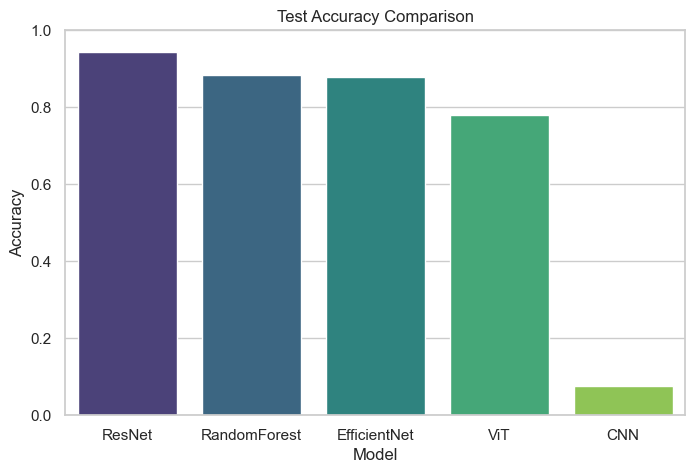

In [ ]:
# график сравнения точности всех моделей
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=metrics_df, palette="viridis")
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


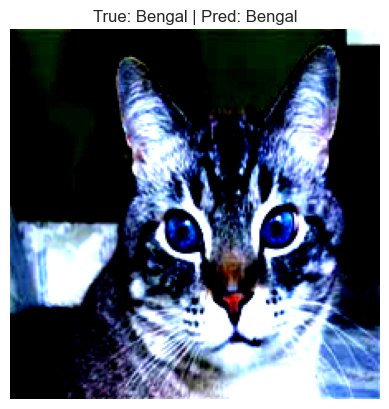

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..2.3935575].


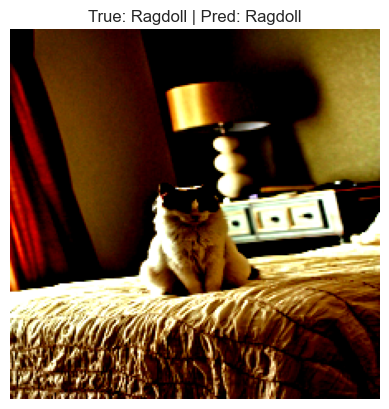

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].


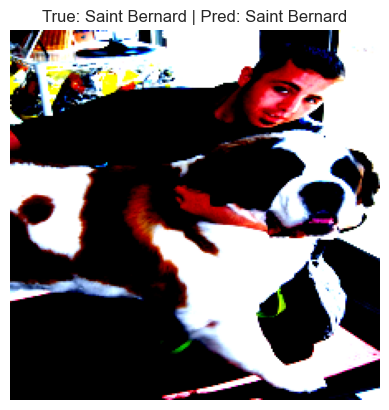

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


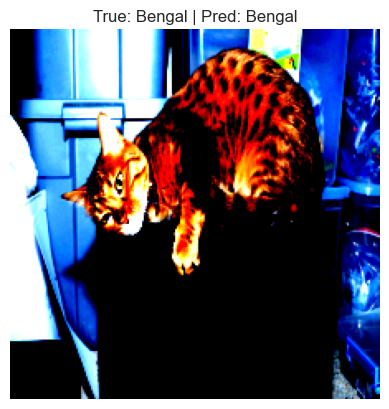

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7347276..2.186841].


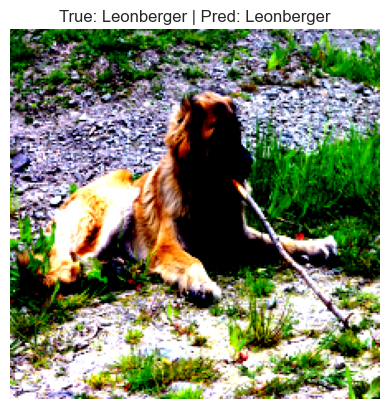

In [66]:
# Визуализация предсказаний лучшей модели (ResNet)
idx2class = {i: c for i, c in enumerate(full_dataset.classes)}

def visualize_prediction(model, dataset, device, idx=0):
    model.eval()
    img, label = dataset[idx]
    true_class = idx2class[label]

    with torch.no_grad():
        out = model(img.unsqueeze(0).to(device))
        pred = out.argmax(dim=1).item()
    pred_class = idx2class[pred]

    # визуализация
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title(f"True: {true_class} | Pred: {pred_class}", fontsize=12)
    plt.show()

import random
for i in random.sample(range(len(test_ds)), 5):
    visualize_prediction(resnet, test_ds, device, idx=i)
